In [24]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True




In [4]:
#### function to import oecd data

import requests as rq
import pandas as pd
import re

OECD_ROOT_URL = "http://stats.oecd.org/SDMX-JSON/data"

def make_OECD_request(dsname, dimensions, params = None, root_dir = OECD_ROOT_URL):
    # Make URL for the OECD API and return a response
    # 4 dimensions: location, subject, measure, frequency
    # OECD API: https://data.oecd.org/api/sdmx-json-documentation/#d.en.330346

    if not params:
        params = {}

    dim_args = ['+'.join(d) for d in dimensions]
    dim_str = '.'.join(dim_args)

    url = root_dir + '/' + dsname + '/' + dim_str + '/all'

    print('Requesting URL ' + url)
    return rq.get(url = url, params = params)


def create_DataFrame_from_OECD(country = 'CZE', subject = [], measure = [], frequency = 'M',  startDate = None, endDate = None):     
    # Request data from OECD API and return pandas DataFrame

    # country: country code (max 1)
    # subject: list of subjects, empty list for all
    # measure: list of measures, empty list for all
    # frequency: 'M' for monthly and 'Q' for quarterly time series
    # startDate: date in YYYY-MM (2000-01) or YYYY-QQ (2000-Q1) format, None for all observations
    # endDate: date in YYYY-MM (2000-01) or YYYY-QQ (2000-Q1) format, None for all observations

    # Data download

    response = make_OECD_request('MEI'
                                 , [[country], subject, measure, [frequency]]
                                 , {'startTime': startDate, 'endTime': endDate, 'dimensionAtObservation': 'AllDimensions'})

    # Data transformation

    if (response.status_code == 200):

        responseJson = response.json()

        obsList = responseJson.get('dataSets')[0].get('observations')

        if (len(obsList) > 0):

            print('Data downloaded from %s' % response.url)

            timeList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'TIME_PERIOD'][0]['values']
            subjectList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'SUBJECT'][0]['values']
            measureList = [item for item in responseJson.get('structure').get('dimensions').get('observation') if item['id'] == 'MEASURE'][0]['values']

            obs = pd.DataFrame(obsList).transpose()
            obs.rename(columns = {0: 'series'}, inplace = True)
            obs['id'] = obs.index
            obs = obs[['id', 'series']]
            obs['dimensions'] = obs.apply(lambda x: re.findall('\d+', x['id']), axis = 1)
            obs['subject'] = obs.apply(lambda x: subjectList[int(x['dimensions'][1])]['id'], axis = 1)
            obs['measure'] = obs.apply(lambda x: measureList[int(x['dimensions'][2])]['id'], axis = 1)
            obs['time'] = obs.apply(lambda x: timeList[int(x['dimensions'][4])]['id'], axis = 1)
            obs['names'] = obs['subject'] + '_' + obs['measure']

            data = obs.pivot_table(index = 'time', columns = ['names'], values = 'series')

            return(data)

        else:

            print('Error: No available records, please change parameters')

    else:

        print('Error: %s' % response.status_code)

In [5]:
### testing 

data = create_DataFrame_from_OECD(country = 'CZE', subject = ['LOCOPCNO'])
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'Q', startDate = '2009-Q1', endDate = '2010-Q1')
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'M', startDate = '2009-01', endDate = '2010-12')
data = create_DataFrame_from_OECD(country = 'USA', frequency = 'M', subject = ['B6DBSI01'])
dataoecd = create_DataFrame_from_OECD(country = 'USA', frequency = 'Q', subject = ['B6DBSI01'])

Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CZE.LOCOPCNO..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CZE.LOCOPCNO..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all?startTime=2009-Q1&endTime=2010-Q1&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...M/all?startTime=2009-01&endTime=2010-12&dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..M/all
Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA.B6DBSI01..Q/all?dimensionAtObservation=AllDimensions


In [6]:
dataoecd.head()  

names    B6DBSI01_CXCU  B6DBSI01_CXCUSA  B6DBSI01_NCCU  B6DBSI01_NCCUSA
time                                                                   
1960-Q1          958.0            955.0          958.0            955.0
1960-Q2         1172.0           1154.0         1172.0           1154.0
1960-Q3          896.0            889.0          896.0            889.0
1960-Q4         1035.0           1064.0         1035.0           1064.0
1961-Q1          991.0            989.0          991.0            989.0

In [7]:
### importing bis data
import pandas as pd 
import urllib
link = "https://www.bis.org/statistics/totcredit/totcredit.xlsx"
databis = pd.read_excel(link, sheet_name = 2)


In [8]:
### inspecting  data
databis.head()

Back to menu  \
0                  NaN   
1                  NaN   
2               Period   
3  1940-06-30 00:00:00   
4  1940-09-30 00:00:00   

  Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - Percentage of GDP - Adjusted for breaks  \
0                                   Per Cent (Units)                                                                                         
1                       Emerging markets (aggregate)                                                                                         
2                                   Q:4T:C:A:M:770:A                                                                                         
3                                                NaN                                                                                         
4                                                NaN                                                                                         

  Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - Percentage of GDP (using PPP exchange rates) - Adjusted for breaks  \
0                                   Per Cent (Units)                                                                                                                    
1                       Emerging markets (aggregate)                                                                                                                    
2                                   Q:4T:C:A:M:799:A                                                                                                                    
3                                                NaN                                                                                                                    
4                                                NaN                                                                                                                    

  Emerging markets (aggregate) - Credit to Non financial sector from All sectors at Market value - US dollar - Adjusted for breaks  \
0                               US dollar (Billions)                                                                                 
1                       Emerging markets (aggregate)                                                                                 
2                                   Q:4T:C:A:M:USD:A                                                                                 
3                                                NaN                                                                                 
4                                                NaN                                                                                 

  Emerging markets (aggregate) - Credit to General government from All sectors at Nominal value - Percentage of GDP - Adjusted for breaks  \
0                                   Per Cent (Units)                                                                                        
1                       Emerging markets (aggregate)                                                                                        
2                                   Q:4T:G:A:N:770:A                                                                                        
3                                                NaN                                                                                        
4                                                NaN                                                                                        

  Emerging markets (aggregate) - Credit to General government from All sectors at Nominal value - Percentage of GDP (using PPP exchange rates) - Adjusted for breaks  \
0                                   Per Cent (Units)                                                                                                                 

In [9]:
### Inspecting world bank  Apis

wbdata.get_source()

1 	Doing Business
2 	World Development Indicators
3 	Worldwide Governance Indicators
5 	Subnational Malnutrition Database
6 	International Debt Statistics
11	Africa Development Indicators
12	Education Statistics
13	Enterprise Surveys
14	Gender Statistics
15	Global Economic Monitor
16	Health Nutrition and Population Statistics
18	IDA Results Measurement System
19	Millennium Development Goals
20	Quarterly Public Sector Debt
22	Quarterly External Debt Statistics SDDS
23	Quarterly External Debt Statistics GDDS
24	Poverty and Equity
25	Jobs
27	Global Economic Prospects
28	Global Financial Inclusion
29	The Atlas of Social Protection: Indicators of Resilience and Equity
30	Exporter Dynamics Database ��� Indicators at Country-Year Level
31	Country Policy and Institutional Assessment
32	Global Financial Development
33	G20 Financial Inclusion Indicators
34	Global Partnership for Education
35	Sustainable Energy for All
36	Statistical Capacity Indicators
37	LAC Equity Lab
38	Subnational Poverty
39

In [10]:
>>> wbdata.get_indicator(source=15)


CORENS       	Core CPI,not seas.adj,,,
CORESA       	Core CPI,seas.adj,,,
CPTOTNSXN    	CPI Price, nominal
CPTOTSAXMZGY 	CPI Price, % y-o-y, median weighted, seas. adj.
CPTOTSAXN    	CPI Price, nominal, seas. adj.
CPTOTSAXNZGY 	CPI Price, % y-o-y, nominal, seas. adj.
DMGSRMRCHNSCD	Imports Merchandise, Customs, current US$, millions
DMGSRMRCHNSKD	Imports Merchandise, Customs, constant US$, millions
DMGSRMRCHNSXD	Imports Merchandise, Customs, Price, US$
DMGSRMRCHSACD	Imports Merchandise, Customs, current US$, millions, seas. adj.
DMGSRMRCHSAKD	Imports Merchandise, Customs, constant US$, millions, seas. adj.
DMGSRMRCHSAXD	Imports Merchandise, Customs, Price, US$, seas. adj.
DPANUSLCU    	Official exchange rate, LCU per USD, period average
DPANUSSPB    	Exchange rate, new LCU per USD extended backward, period average
DPANUSSPF    	Exchange rate, old LCU per USD extended forward, period average
DSTKMKTXD    	Stock Markets, US$
DSTKMKTXN    	Stock Markets, LCU
DXGSRMRCHNSCD	Exports Merchandi

In [11]:
### fecthing country names from IMF database
countrycodes = pd.read_csv('CountryCodes.csv', delimiter = ';')
countrycodes.head()



IMF Name ISO Code  IMF Code
0  Afghanistan      AFG     512.0
1      Albania      ALB     914.0
2      Algeria      DZA     612.0
3       Angola      AGO     614.0
4    Argentina      ARG     213.0

In [35]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["NEER", "REER", "TOT", "TOTRESV","UNEMPSA_", "RETSALESSA",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator = ["NEER", "REER", "TOT", "TOTRESV","UNEMPSA_", "RETSALESSA",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["NEER", "REER", "TOT", "TOTRESV","UNEMPSA_", "RETSALESSA",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])



In [36]:
#describe data
worldbank_data.describe()




NEER          REER           TOT       TOTRESV      UNEMPSA_  \
count  3.458900e+04  33022.000000  12732.000000  5.218400e+04  19790.000000   
mean   3.184837e+07    104.636024      1.011335  3.603876e+04      8.294399   
std    2.174199e+09    106.267135      0.204521  1.841123e+05      5.281104   
min    9.912381e+00     14.781424      0.312999 -5.657242e+02      0.100000   
25%    9.474356e+01     91.087442      0.938058  3.130786e+02      4.800000   
50%    1.012471e+02     99.283210      0.994608  2.162680e+03      7.187114   
75%    1.151297e+02    107.268797      1.052340  1.599192e+04     10.200000   
max    2.496987e+11   5407.037675      3.792759  4.012667e+06     38.364440   

        RETSALESSA     IPTOTSAKD  DXGSRMRCHSAKD     DSTKMKTXD  DMGSRMRCHSAKD  \
count  7533.000000  2.681000e+04   1.147800e+04  19680.000000   36774.000000   
mean     88.128831  1.601277e+10   1.723723e+07     89.770858    7219.449515   
std      32.107710  4.253415e+10   1.781422e+08     73.691988   19406.937786   
min       0.147705  1.046696e+06   3.429761e+00      0.000000  -15721.143112   
25%      68.856851  8.834633e+08   5.384433e+03     45.071476     200.832945   
50%      89.522300  4.403469e+09   1.243873e+04     82.943066     943.579056   
75%     104.403590  1.201325e+10   3.039115e+04    116.573450    5491.512392   
max     443.216212  8.680251e+11   2.441316e+09   1764.233542  224429.809309   

          CPTOTSAXN  
count  5.060400e+04  
mean   3.655452e+04  
std    4.435865e+06  
min    6.792600e-07  
25%    5.886212e+01  
50%    8.402654e+01  
75%    1.081065e+02  
max    8.638368e+08

MultiIndex(levels=[['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo Dem. Rep.', 'Congo Rep.', 'Costa Rica', 'Cote d'Ivoire', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt Arab Rep.', 'El Salvador', 'Eritrea', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia The', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong China', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran Islamic Re

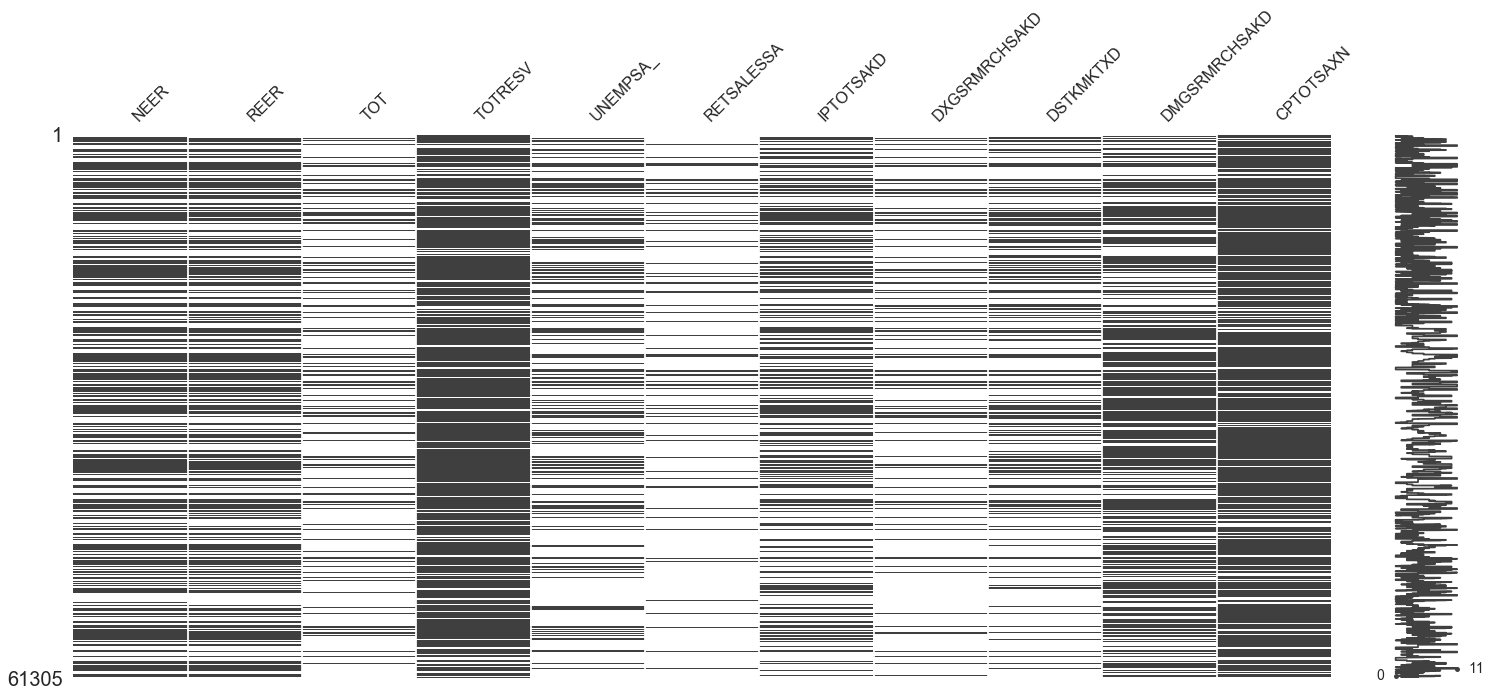

In [25]:
### missing data

import missingno as msno
msno.matrix(worldbank_data)




In [62]:
def count_missing(frame):
    return (frame.shape[0] * frame.shape[1]) - frame.count().sum()

nan_by_country = worldbank_data.groupby(worldbank_data.index.names.difference(["year"])).apply(count_missing)
nan_by_country = nan_by_country[nan_by_country < 1500]
nan_by_country

country
Argentina             1073
Australia              787
Austria               1058
Belgium                166
Brazil                 349
Bulgaria              1359
Canada                 221
Chile                  671
China                 1005
Colombia              1140
Croatia               1379
Czech Republic         492
Denmark                365
Estonia               1444
Finland                250
France                 228
Germany                154
Greece                 762
Hong Kong China        601
Hungary                515
India                 1326
Indonesia             1052
Ireland                216
Israel                 791
Italy                  470
Japan                   62
Jordan                1282
Korea Rep.             337
Latvia                1238
Luxembourg            1274
Malaysia              1103
Mexico                 232
Netherlands            414
Norway                 459
Pakistan              1302
Peru                   675
Philippines         

In [73]:
selected_worldbank_data = worldbank_data[worldbank_data.index.get_level_values(0).isin(nan_by_country.index)]
selected_worldbank_data.sort_values(by = "year").profile_report(style={'full_width':True})

In [60]:
### Creating dictionary of variables 

dictionary = dict([('NYGDPMKTPKDZ','Annual GDP Growth 2010'), 
                   ('CC.EST','Control of Corruption Estimate'),
               ('RL.EST'    ,  'Rule of Law: Estimate'),
               ('RQ.EST'    ,   'Regulatory Quality: Estimate'),
               ('VA.EST'    ,   'Voice and Accountability: Estimate'),
              (' PV.EST'    ,   'Political Stability and Absence of Violence/Terrorism: Estimate'),
                  ('CORENS'       ,'Core CPI,not seas.adj'),
                ('CORESA'        ,'Core CPI,seas.adj'),
                ('CPTOTNSXN'    ,'CPI Price, nominal'),
                ('CPTOTSAXMZGY' ,'CPI Price, % y-o-y, median weighted, seas. adj.'),
                ('CPTOTSAXN'    ,'CPI Price, nominal, seas. adj.'),
                ('CPTOTSAXNZGY' ,'CPI Price, % y-o-y, nominal, seas. adj.'),
                ('DMGSRMRCHNSCD','Imports Merchandise, Customs, current US$, millions'),
                ('DMGSRMRCHNSKD','Imports Merchandise, Customs, constant US$, millions'),
                ('DMGSRMRCHNSXD','Imports Merchandise, Customs, Price, US$'),
                ('DMGSRMRCHSACD','Imports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DMGSRMRCHSAKD','Imports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DMGSRMRCHSAXD','Imports Merchandise, Customs, Price, US$, seas. adj.'),
                ('DPANUSLCU'    ,'Official exchange rate, LCU per USD, period average'),
                ('DPANUSSPB'    ,'Exchange rate, new LCU per USD extended backward, period average'),
                ('DPANUSSPF'    ,'Exchange rate, old LCU per USD extended forward, period average'),
                ('DSTKMKTXD'    ,'Stock Markets, US$'),
                ('DSTKMKTXN'    ,'Stock Markets, LCU'),
                ('DXGSRMRCHNSCD' ,'Exports Merchandise, Customs, current US$, millions'),
                ('DXGSRMRCHNSKD' ,'Exports Merchandise, Customs, constant US$, millions'),
                ('DXGSRMRCHNSXD' ,'Exports Merchandise, Customs, Price, US$'),
                ('DXGSRMRCHSACD' , 'Exports Merchandise, Customs, current US$, millions, seas. adj.'),
                ('DXGSRMRCHSAKD' ,'Exports Merchandise, Customs, constant US$, millions, seas. adj.'),
                ('DXGSRMRCHSAXD' ,'Exports Merchandise, Customs, Price, US$, seas. adj.'),
                ('EMBIG'        ,'J.P. Morgan Emerging Markets Bond Spread (EMBI+'),
                ('EMBIGI'       ,'J.P. Morgan Emerging Markets Bond Index(EMBI+'),
                ('IMPCOV'       ,'Foreign Reserves, Months Import Cover, Goods'),
                ('IPTOTNSKD'    ,'Industrial Production, constant US$'),
                ('IPTOTSAKD'    ,'Industrial Production, constant US$, seas. adj.'),
                ('NEER'         ,'Nominal Effecive Exchange Rate'),
                ('NYGDPMKTPSACD' ,'GDP,current US$,millions,seas. adj.'),
                ('NYGDPMKTPSACN' ,'GDP,current LCU,millions,seas. adj.'),
                ('NYGDPMKTPSAKD' ,'GDP,constant 2010 US$,millions,seas. adj.'),
                ('NYGDPMKTPSAKN' ,'GDP,constant 2010 LCU,millions,seas. adj.'),
                ('REER'          ,'Real Effective Exchange Rate'),
                ('RETSALESSA'    ,'Retail Sales Volume,Index,'),
                ('TOT'           ,'Terms of Trade'),
                ('TOTRESV'       ,'Total Reserves'),
                ('UNEMPSA_'      ,'Unemployment rate,Percent')
                  ])

In [61]:
### Testing Dictionary 

dictionary['TOT']

'Terms of Trade'

In [62]:
### structuring dates 

data_dates = (datetime.datetime(2001,1,1), datetime.datetime(2015,1,1))

In [63]:
### Creating indicator to input into api

indicator={'IMPCOV':'Foreign Reserves',
       'IPTOTSAKD':'Industrial Production',
       'NYGDPMKTPSAKD':'GDP,constant 2010',
       'CORESA':'Core CPI',
       'RL.EST':'Rule of Law: Estimate',
       'PV.EST':'Political Stability and Absence of Violence/Terrorism: Estimate',
       'NEER':'Nominal Effecive Exchange Rate',
       'DSTKMKTXD':'Stock Markets USD',
       'EMBIG':'J.P. Morgan Emerging Markets Bond Spread'
    }

In [64]:
### Building dataframe from APIs

df=wbdata.get_dataframe(indicator,country='all')

In [65]:
# inspecting dataframe
df.head()

Foreign Reserves  Industrial Production  \
country            date                                            
Advanced Economies 1987               NaN                    NaN   
                   1988               NaN                    NaN   
                   1989               NaN                    NaN   
                   1990               NaN                    NaN   
                   1991          0.232183           7.210007e+12   

                         GDP,constant 2010   Core CPI  Rule of Law: Estimate  \
country            date                                                        
Advanced Economies 1987       2.534444e+07  56.117876                    NaN   
                   1988       2.657258e+07  58.304588                    NaN   
                   1989       2.761582e+07  60.852758                    NaN   
                   1990       2.841970e+07  63.723075                    NaN   
                   1991       2.880091e+07  66.586229                    NaN   

                         Political Stability and Absence of Violence/Terrorism: Estimate  \
country            date                                                                    
Advanced Economies 1987                                                NaN                 
                   1988                                                NaN                 
                   1989                                                NaN                 
                   1990                                                NaN                 
                   1991                                                NaN                 

                         Nominal Effecive Exchange Rate  Stock Markets USD  \
country            date                                                      
Advanced Economies 1987                       76.776320                NaN   
                   1988                       78.932198                NaN   
                   1989                       82.927398                NaN   
                   1990                       86.575677                NaN   
                   1991                       88.445536                NaN   

                         J.P. Morgan Emerging Markets Bond Spread  
country            date                                            
Advanced Economies 1987                                       NaN  
                   1988                                       NaN  
                   1989                                       NaN  
                   1990                                       NaN  
                   1991                                       NaN

In [66]:
data = df.reset_index()


In [58]:
data.head()

country  date  Foreign Reserves  Industrial Production  \
0  Advanced Economies  1987               NaN                    NaN   
1  Advanced Economies  1988               NaN                    NaN   
2  Advanced Economies  1989               NaN                    NaN   
3  Advanced Economies  1990               NaN                    NaN   
4  Advanced Economies  1991          0.232183           7.186165e+12   

   GDP,constant 2010   Core CPI  Rule of Law: Estimate  \
0       2.537671e+07  56.117876                    NaN   
1       2.660831e+07  58.304588                    NaN   
2       2.765369e+07  60.852758                    NaN   
3       2.845964e+07  63.721509                    NaN   
4       2.883952e+07  66.584499                    NaN   

   Political Stability and Absence of Violence/Terrorism: Estimate  \
0                                                NaN                 
1                                                NaN                 
2                                                NaN                 
3                                                NaN                 
4                                                NaN                 

   Nominal Effecive Exchange Rate  Stock Markets USD  \
0                       76.776320                NaN   
1                       78.932198                NaN   
2                       82.927398                NaN   
3                       86.575677                NaN   
4                       88.445536                NaN   

   J.P. Morgan Emerging Markets Bond Spread  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4                                       NaN

In [ ]:
#### Profiling dataframe 

data.profile_report(style={'full_width':True})

# Data Wrangling

The following chunks of code will be devoted to wrangle the database

In [67]:
### DataWranling

## importing data base

import pandas as pd

dataset = pd.read_csv('full_data2.csv', parse_dates = ['TIME'], index_col = ["Country"])
dataset.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                     
Albania           1 1989-08-01         NaN      NaN       NaN         NaN   
Albania           2 1989-09-01         NaN      NaN       NaN         NaN   
Albania           3 1989-10-01         NaN      NaN       NaN         NaN   
Albania           4 1989-11-01         NaN      NaN       NaN         NaN   
Albania           5 1989-12-01         NaN      NaN       NaN         NaN   

         NOMexchange  REexchange  industrialprod  stock  unemployment  \
Country                                                                 
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   

         foreignreserver  CPI  
Country                        
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN

In [69]:
dataset.describe()

Unnamed: 0    nominalgdp      housepi      fixedcap   accountgdp  \
count  73136.000000  8.690000e+03  5740.000000  5.197000e+03  4859.000000   
mean   36568.500000  4.156439e+07    62.455471  2.716927e+06    -0.291864   
std    21112.688981  2.658507e+08    38.885243  1.323544e+07     5.288994   
min        1.000000  9.994000e+01     0.713413  1.277010e+02   -32.020580   
25%    18284.750000  4.264482e+04    27.517800  1.034500e+04    -3.172560   
50%    36568.500000  2.165010e+05    62.668566  4.833845e+04    -0.628533   
75%    54852.250000  1.101636e+06    95.998673  1.860380e+05     2.127498   
max    73136.000000  4.310000e+09   174.292423  1.483516e+08    43.330140   

         NOMexchange    REexchange  industrialprod         stock  \
count   29821.000000  31942.000000    2.602600e+04  16016.000000   
mean     1433.786022    103.670676    7.381786e+10     92.274566   
std     21011.923020    102.566881    2.057159e+11     77.856230   
min        29.190170     32.259500    2.956468e+07      0.000135   
25%        95.706680     92.470553    1.110000e+09     49.190040   
50%       100.776100     99.293485    6.490000e+09     84.174565   
75%       110.676200    105.473650    2.930000e+10    116.132350   
max    463330.200000   5102.158000    1.750000e+12   1765.503000   

       unemployment  foreignreserver           CPI  
count  21293.000000     37976.000000  49636.000000  
mean       8.439291       239.827706     89.818226  
std        5.410932      1489.599348     38.533625  
min        0.100000         0.001329      0.000319  
25%        5.019923         2.757993     70.045973  
50%        7.170125         5.246678     90.466725  
75%       10.100000         9.934603    109.199450  
max       38.364440     28072.150000    530.559300

In [72]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73136 entries, Albania to Kosovo
Data columns (total 13 columns):
Unnamed: 0         73136 non-null int64
TIME               72940 non-null datetime64[ns]
nominalgdp         8690 non-null float64
housepi            5740 non-null float64
fixedcap           5197 non-null float64
accountgdp         4859 non-null float64
NOMexchange        29821 non-null float64
REexchange         31942 non-null float64
industrialprod     26026 non-null float64
stock              16016 non-null float64
unemployment       21293 non-null float64
foreignreserver    37976 non-null float64
CPI                49636 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 7.8+ MB


Creating list of countries in order to remove regions such as: advanced economies, emerging markets... and leaving just standalone countries

In [73]:
#### creating list of countries

list = pd.DataFrame(dataset.index.unique())
list.head()

Country
0    Albania
1  Argentina
2    Armenia
3  Australia
4    Austria

In [74]:
### fecthing country names from IMF database
countrycodes = pd.read_csv('CountryCodes.csv', delimiter = ';')
countrycodes.head()



IMF Name ISO Code  IMF Code
0  Afghanistan      AFG     512.0
1      Albania      ALB     914.0
2      Algeria      DZA     612.0
3       Angola      AGO     614.0
4    Argentina      ARG     213.0

In [75]:
### removing regions and keeping only standalone countries
dataset2 = dataset[dataset.index.isin(countrycodes['IMF Name'])]
dataset2.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                     
Albania           1 1989-08-01         NaN      NaN       NaN         NaN   
Albania           2 1989-09-01         NaN      NaN       NaN         NaN   
Albania           3 1989-10-01         NaN      NaN       NaN         NaN   
Albania           4 1989-11-01         NaN      NaN       NaN         NaN   
Albania           5 1989-12-01         NaN      NaN       NaN         NaN   

         NOMexchange  REexchange  industrialprod  stock  unemployment  \
Country                                                                 
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   

         foreignreserver  CPI  
Country                        
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN

In [14]:
### Checking if there are only standalone countries
list2 = pd.DataFrame(dataset2.index.unique())
list2

Country
0                   Albania
1                 Argentina
2                   Armenia
3                 Australia
4                   Austria
5                   Belgium
6                  Bulgaria
7                   Bahrain
8    Bosnia and Herzegovina
9                   Belarus
10                  Bolivia
11                   Brazil
12                 Botswana
13                   Canada
14              Switzerland
15                    Chile
16                    China
17                 Colombia
18               Costa Rica
19                   Cyprus
20           Czech Republic
21                  Germany
22                  Denmark
23                  Ecuador
24                    Spain
25                  Estonia
26                  Finland
27                   France
28           United Kingdom
29                  Georgia
..                      ...
123              Cabo Verde
124                Djibouti
125                Ethiopia
126                  Guinea
127                   Haiti
128         Kyrgyz Republic
129                   Libya
130              Madagascar
131                Maldives
132                 Myanmar
133              Mozambique
134              Mauritania
135                  Rwanda
136                Suriname
137              Seychelles
138              Tajikistan
139                   Tonga
140             Afghanistan
141                   Benin
142            Burkina Faso
143                  Bhutan
144                Cambodia
145                Kiribati
146                 Liberia
147                    Mali
148                 Namibia
149                   Niger
150                   Nepal
151                    Chad
152             Timor-Leste

[153 rows x 1 columns]

In [76]:
dataset3 = dataset2[(dataset2['TIME']) > pd.Timestamp(1990,1,1)]
dataset3.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                     
Albania           7 1990-02-01         NaN      NaN       NaN         NaN   
Albania           8 1990-03-01         NaN      NaN       NaN         NaN   
Albania           9 1990-04-01         NaN      NaN       NaN         NaN   
Albania          10 1990-05-01         NaN      NaN       NaN         NaN   
Albania          11 1990-06-01         NaN      NaN       NaN         NaN   

         NOMexchange  REexchange  industrialprod  stock  unemployment  \
Country                                                                 
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   
Albania          NaN         NaN             NaN    NaN           NaN   

         foreignreserver  CPI  
Country                        
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN  
Albania              NaN  NaN

In [77]:
### checking dataset3
dataset3.describe()

Unnamed: 0    nominalgdp      housepi      fixedcap   accountgdp  \
count  53434.000000  7.756000e+03  3718.000000  4.304000e+03  3834.000000   
mean   34445.767957  2.883775e+07    79.614069  3.250686e+06    -0.283120   
std    21763.176589  2.146546e+08    31.740278  1.448663e+07     5.791652   
min        7.000000  1.354800e+02     5.787204  1.277010e+02   -32.020580   
25%    15267.250000  4.066595e+04    55.664000  1.069766e+04    -3.497481   
50%    31647.500000  1.921126e+05    83.585580  5.774001e+04    -0.896225   
75%    55954.750000  8.443497e+05   101.648618  1.849609e+05     2.705963   
max    72774.000000  3.860000e+09   174.292423  1.483516e+08    43.330140   

         NOMexchange    REexchange  industrialprod         stock  \
count   22233.000000  23304.000000    2.010600e+04  13173.000000   
mean     1558.779720     98.672939    1.918814e+10     93.238428   
std     24036.229625     14.573895    4.828724e+10     81.775305   
min        29.190170     32.259500    2.956468e+07      1.767549   
25%        95.107030     92.231388    9.632500e+08     49.368170   
50%       100.345300     98.829295    5.060000e+09     84.187740   
75%       109.073500    104.692275    1.290000e+10    117.692700   
max    463330.200000    196.024700    5.040000e+11   1765.503000   

       unemployment  foreignreserver           CPI  
count  16123.000000     30957.000000  38419.000000  
mean       8.310464       261.175767     90.151053  
std        5.042546      1600.296341     39.073366  
min        0.100000         0.001329      0.000321  
25%        4.960074         2.620088     70.567525  
50%        7.270071         4.909120     90.705040  
75%       10.200000         9.268885    108.860400  
max       29.500000     28072.150000    530.559300

In [78]:
### sorting values in dataset3 and assigning it to dataset4
dataset4 = dataset3.sort_values(by='TIME')
dataset4.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                        
Albania              7 1990-02-01         NaN      NaN       NaN         NaN   
Botswana          4543 1990-02-01         NaN      NaN       NaN         NaN   
Djibouti         59473 1990-02-01         NaN      NaN       NaN         NaN   
Cabo Verde       59111 1990-02-01         NaN      NaN       NaN         NaN   
Canada            5020 1990-02-01         NaN      NaN       NaN         NaN   

            NOMexchange  REexchange  industrialprod  stock  unemployment  \
Country                                                                    
Albania             NaN         NaN             NaN    NaN           NaN   
Botswana            NaN         NaN             NaN    NaN           NaN   
Djibouti            NaN         NaN             NaN    NaN           NaN   
Cabo Verde          NaN         NaN             NaN    NaN           NaN   
Canada              NaN         NaN             NaN    NaN           7.7   

            foreignreserver     CPI  
Country                              
Albania                 NaN     NaN  
Botswana                NaN     NaN  
Djibouti                NaN     NaN  
Cabo Verde              NaN     NaN  
Canada                  NaN  66.604

### Choosing Sample size

Here we define the sample size that is going to be inserted into the pipeline. 

The idea here is to have flexibility and to try different choices.

i) First option is to follow ECB paper plus countries that are richer in data.




In [79]:
### fetching data from oecdplus
oecdplus =pd.read_csv('oecdplus.csv', parse_dates = True)
oecdplus                                    
                                    

Unnamed: 0    Country        TIME  accountgdp
0              1  Australia  1959-07-01   -2.622289
1              2  Australia  1959-10-01    0.073493
2              3  Australia  1960-01-01   -1.561749
3              4  Australia  1960-04-01   -3.408831
4              5  Australia  1960-07-01   -5.508764
5              6  Australia  1960-10-01   -4.319313
6              7  Australia  1961-01-01   -3.534209
7              8  Australia  1961-04-01    0.046339
8              9  Australia  1961-07-01    0.624277
9             10  Australia  1961-10-01    2.270122
10            11  Australia  1962-01-01    0.601202
11            12  Australia  1962-04-01    0.021796
12            13  Australia  1962-07-01   -2.820844
13            14  Australia  1962-10-01   -1.256544
14            15  Australia  1963-01-01   -1.159008
15            16  Australia  1963-04-01   -1.126357
16            17  Australia  1963-07-01   -0.369434
17            18  Australia  1963-10-01    1.961905
18            19  Australia  1964-01-01    0.753012
19            20  Australia  1964-04-01   -0.819225
20            21  Australia  1964-07-01   -2.492379
21            22  Australia  1964-10-01   -2.188640
22            23  Australia  1965-01-01   -3.183296
23            24  Australia  1965-04-01   -3.189525
24            25  Australia  1965-07-01   -4.382737
25            26  Australia  1965-10-01   -3.653497
26            27  Australia  1966-01-01   -2.712032
27            28  Australia  1966-04-01   -1.650112
28            29  Australia  1966-07-01   -1.869159
29            30  Australia  1966-10-01   -1.808399
...          ...        ...         ...         ...
4829        4830        G20  2011-07-01   -0.367972
4830        4831        G20  2011-10-01   -0.282770
4831        4832        G20  2012-01-01   -0.376868
4832        4833        G20  2012-04-01   -0.260520
4833        4834        G20  2012-07-01   -0.126492
4834        4835        G20  2012-10-01   -0.419288
4835        4836        G20  2013-01-01   -0.195766
4836        4837        G20  2013-04-01   -0.194538
4837        4838        G20  2013-07-01   -0.233004
4838        4839        G20  2013-10-01   -0.234006
4839        4840        G20  2014-01-01   -0.440357
4840        4841        G20  2014-04-01    0.100989
4841        4842        G20  2014-07-01   -0.020160
4842        4843        G20  2014-10-01   -0.086337
4843        4844        G20  2015-01-01    0.204647
4844        4845        G20  2015-04-01   -0.033147
4845        4846        G20  2015-07-01   -0.217091
4846        4847        G20  2015-10-01   -0.044547
4847        4848        G20  2016-01-01    0.025799
4848        4849        G20  2016-04-01    0.224596
4849        4850        G20  2016-07-01    0.217463
4850        4851        G20  2016-10-01   -0.141412
4851        4852        G20  2017-01-01    0.155266
4852        4853        G20  2017-04-01   -0.244058
4853        4854        G20  2017-07-01    0.205839
4854        4855        G20  2017-10-01    0.130579
4855        4856        G20  2018-01-01   -0.256075
4856        4857        G20  2018-04-01    0.020625
4857        4858        G20  2018-07-01   -0.014961
4858        4859        G20  2018-10-01    0.001662

[4859 rows x 4 columns]

In [80]:
### list of oecd plus affiliated countries
oecdlist = pd.DataFrame(oecdplus.Country.unique())
oecdlist

0
0                       Australia
1                           Korea
2                   United States
3                          Canada
4                           Japan
5                     New Zealand
6                           Chile
7                     Switzerland
8                         Finland
9                  United Kingdom
10                        Denmark
11                       Slovenia
12                         Greece
13                    Netherlands
14                 Czech Republic
15                        Hungary
16                          Spain
17                          Italy
18                        Germany
19                     Luxembourg
20                        Iceland
21                         Poland
22                Slovak Republic
23                        Ireland
24                        Belgium
25                         France
26                        Austria
27                         Norway
28                       Portugal
29                        Estonia
30                         Turkey
31                         Sweden
32                       Colombia
33                         Israel
34                         Latvia
35                   OECD - Total
36                             G7
37                         Russia
38                      Indonesia
39                         Brazil
40                          India
41                      Lithuania
42                   South Africa
43  European Union (28 countries)
44       Euro area (19 countries)
45                     Costa Rica
46   China (People's Republic of)
47                   Saudi Arabia
48                         Mexico
49                      Argentina
50                            G20

In [81]:
### keeping only oecd plus countries
dataset5 = dataset4[dataset4.index.isin(oecdplus['Country'])]
dataset5.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                         
Canada             5020 1990-02-01         NaN      NaN       NaN         NaN   
Switzerland        5461 1990-02-01         NaN      NaN       NaN         NaN   
Chile              5823 1990-02-01         NaN      NaN       NaN         NaN   
Colombia           6554 1990-02-01         NaN      NaN       NaN         NaN   
Denmark            8522 1990-02-01         NaN      NaN       NaN         NaN   

             NOMexchange  REexchange  industrialprod     stock  unemployment  \
Country                                                                        
Canada               NaN         NaN             NaN       NaN        7.7000   
Switzerland          NaN         NaN             NaN  18.45491        0.4568   
Chile                NaN         NaN             NaN       NaN           NaN   
Colombia             NaN         NaN             NaN       NaN           NaN   
Denmark              NaN         NaN             NaN       NaN           NaN   

             foreignreserver        CPI  
Country                                  
Canada                   NaN  66.604000  
Switzerland              NaN  74.045400  
Chile                    NaN  27.254190  
Colombia                 NaN   8.569616  
Denmark                  NaN  66.228190

In [82]:
### selecting unique values in dataset5
list3 = pd.DataFrame(dataset5.index.unique())

In [83]:
#### List of selected countries
list3

Country
0            Canada
1       Switzerland
2             Chile
3          Colombia
4           Denmark
5           Germany
6    Czech Republic
7        Costa Rica
8         Argentina
9         Australia
10          Austria
11          Belgium
12           Brazil
13        Indonesia
14         Portugal
15           Poland
16            India
17          Ireland
18      New Zealand
19           Norway
20          Iceland
21      Netherlands
22           Israel
23            Japan
24        Lithuania
25       Luxembourg
26           Latvia
27           Mexico
28            Italy
29          Hungary
30     Saudi Arabia
31   United Kingdom
32           France
33          Finland
34          Estonia
35            Spain
36     South Africa
37         Slovenia
38           Sweden
39           Turkey
40           Greece
41    United States
42            Korea
43  Slovak Republic
44           Russia

In [84]:
### sorting values in dataset5 and assigning it to dataset6
dataset6 = dataset5.sort_values(by='TIME')
dataset6.head()

Unnamed: 0       TIME  nominalgdp  housepi  fixedcap  accountgdp  \
Country                                                                        
Canada            5020 1990-02-01         NaN      NaN       NaN         NaN   
Japan            18205 1990-02-01         NaN      NaN       NaN         NaN   
Lithuania        20361 1990-02-01         NaN      NaN       NaN         NaN   
Luxembourg       20723 1990-02-01         NaN      NaN       NaN         NaN   
Latvia           21085 1990-02-01         NaN      NaN       NaN         NaN   

            NOMexchange  REexchange  industrialprod  stock  unemployment  \
Country                                                                    
Canada              NaN         NaN             NaN    NaN      7.700000   
Japan               NaN         NaN             NaN    NaN      2.224679   
Lithuania           NaN         NaN             NaN    NaN           NaN   
Luxembourg          NaN         NaN             NaN    NaN           NaN   
Latvia              NaN         NaN             NaN    NaN           NaN   

            foreignreserver       CPI  
Country                                
Canada                  NaN  66.60400  
Japan                   NaN  93.29809  
Lithuania               NaN       NaN  
Luxembourg              NaN  64.36642  
Latvia                  NaN       NaN

In [32]:
### Profiling dataset6
profile = dataset6.profile_report(style={'full_width':True})
profile.to_file(output_file="output.html")

In [85]:
dataset7.profile_report(style={'full_width':True})

In [ ]:
### Interpolation?

one option: MICE strategy statstools
    
    

In [87]:
dataset7 = dataset6.groupby('Country').transform(pd.DataFrame.interpolate)
dataset6.to_csv("teste.csv")

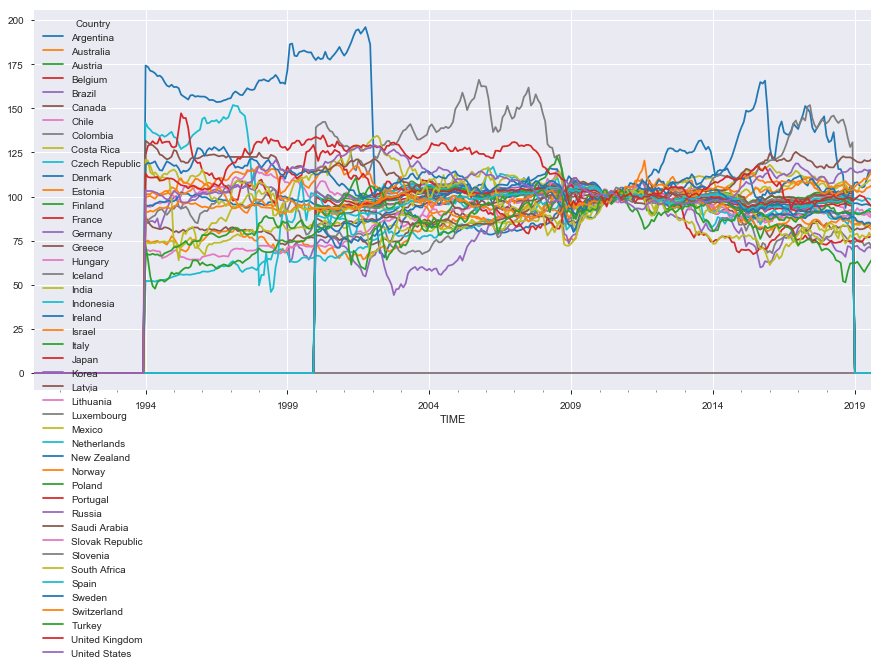

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
dataset6.groupby(['TIME','Country']).sum()['REexchange'].unstack().plot(ax=ax)

In [48]:
import seaborn as sns
ax = sns.lineplot(x="TIME", y="nominalgdp", hue="Country", data=dataset7)

ValueError: Could not interpret input 'Country'

In [51]:
dataset7.to_csv('File Name.csv')

## Dependent Variable and Sensitivity Analysis

In this section we are going to create different kinds of target (dependent) variables based on the research papers from the ECB.

i) Nominal Exchange Depreciation > 20%
ii) Sistemic Banking Crises


This tool is inteded to be flexible enough as to allow the inputation of different cenarios. 



In [ ]:
### building dependent variables and sensitivity analysis

# Create a new column called df.target where the value is 1
# if df.debt is greater than 90 and 0 if not
df['target'] = np.where(df['debt']>=50, '1', '0')

# nominal exchange rate depreciation

## monthly time series

### ten or twenty depreciation in a monthly 

# nominal exchange rate


### list of historical crises 


### Stationarity

This section is devoted to buid a tool for assessing stationarity in the dataframe´s time series.

In [17]:
### stationarity and non stationarity discussion 
from statsmodels.tsa.stattools import adfuller

def stationarity test
"Loop over df and run stationarity tests in each column"
for column in df:
    apply.(adfuller)
    return 
    
    
adf_test = adfuller(data['B6DBSI01_CXCU'])
adf_test


(2.9061435259309514,
 1.0,
 12,
 224,
 {'1%': -3.459884913337196,
  '5%': -2.8745310704320794,
  '10%': -2.573693840082908},
 4051.4409350527517)

In [ ]:
### build indicators


In [85]:
### Preparing machine learning pipeline 

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


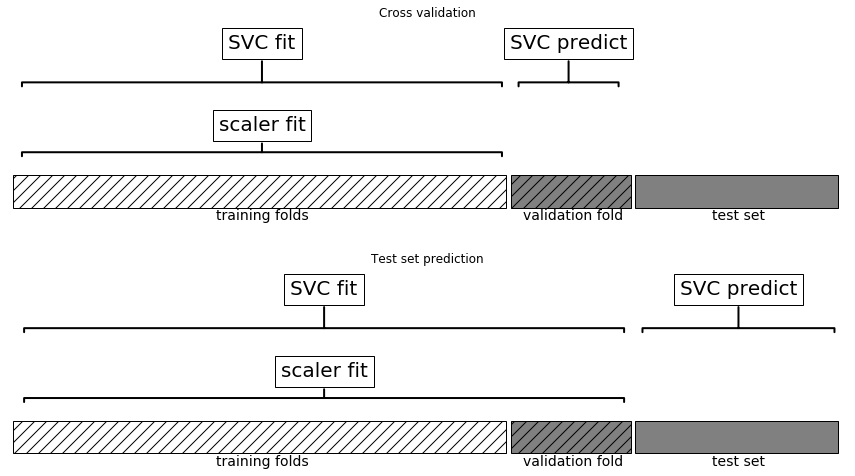

In [89]:
#### Describing what a ML pipeline looks like.

import mglearn 
mglearn.plots.plot_proper_processing()

In [102]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [103]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [104]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


In [105]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [106]:
pipe.fit(X_train, y_train)

C:\Users\leomf\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [107]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [108]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


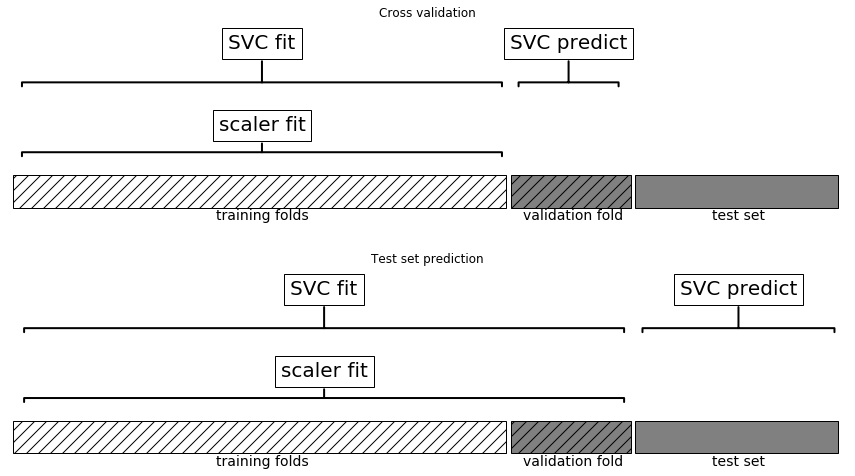

In [109]:
mglearn.plots.plot_proper_processing()